<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time-series forecasting with TensorFlow

What are we going to cover?
1. Get a time series data (the historical price of Bitcoin)
  * Load time series data using Pandas/Python CSV
2. Format data for a time series problem
  * Creating a training and test set wrong way
  * Creating a training and test set right way
  * Visualizing time series data
  * Turning time series model into supervised learning problem ( Windowing )
  * Preparing Univariate and Multivariable ( more than one variable ) data

3. Evaluating a time series model
4. Setting up a series for deep leaning modelling experiments
  * Dense fully connected
  * Sequence model ( LSTM and 1D CNN )
  * Ensembling ( combining multiple models together )
  * Multivariate models
  * Replicating the N-Beats algorithm using Tensorflow Layer subclassing
5. Creating a modelling checkpoint to save best performing model
6. Making predictions (forecast) with time series model.
7. Creating prediction intervals for time series forecasts.


## 1. Get the data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-29 00:56:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2023-07-29 00:56:10 (53.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### 1.1 Import time series data with Pandas

In [2]:
import pandas as pd
price_df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
                 ,parse_dates=["Date"]
                 ,index_col=["Date"]
                 )

price_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(price_df)

2787

🔑note: The frequency at which time series data is collected is often referred to as **seasonality**. Seasonality is often measured as number of samples / year.

In [5]:
# We only want the closing price
daily_price_df = pd.DataFrame(price_df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
daily_price_df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


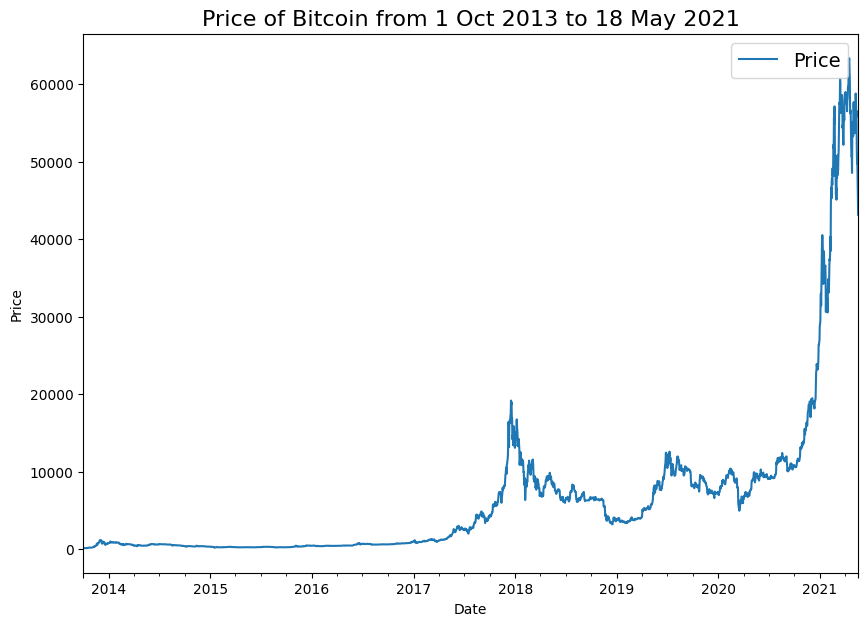

In [6]:
import matplotlib.pyplot as plt
daily_price_df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## 2. Creating the training and test set
### 2.1 The wrong way

In [7]:
# Convert our dataframe index and columns to numpy arrays
timesteps = daily_price_df.index.to_numpy()
prices = daily_price_df["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(timesteps
                                                   ,prices
                                                   ,test_size=0.2
                                                   ,random_state=42)
len(X_train),len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

### 2.2 Let's visualize the splits

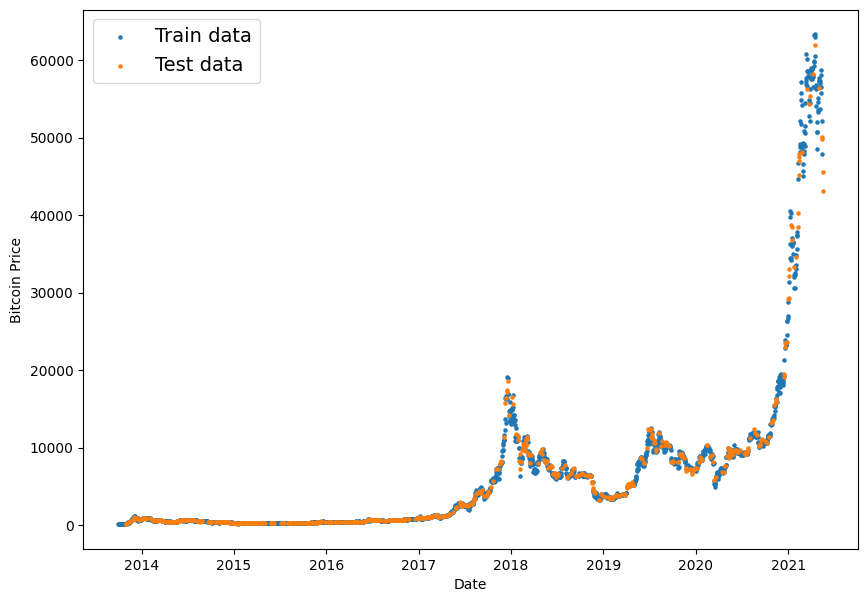

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

As we can see in the above plot our test data is scattered across the training data. This kind of random split works great with data where there is no temporal (time) component. But when time component is invovled, we need to split the data in such a way that it should reflect our purpose. The purpose here is to analyze the historical price and predict or forecast the future price.

### 2.3 Creating the train test split the right way

In [10]:
split_size = int(0.8* len(prices))

X_train,y_train = timesteps[:split_size],prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

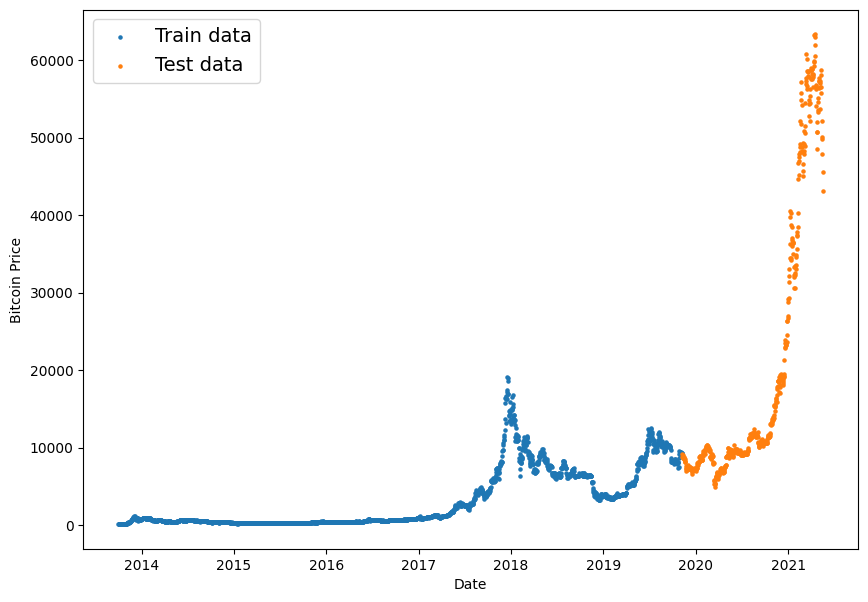

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

## Model 0: Navive Forecast ( baseline )
As usual lets start with a baseline.
One of the most common baseline for time series forecasting, the naive model requires no training.
That's because all that the naive model does is forecast the next timestep value based on previous timestep value.
The formula looks like:

̂y<sub>t</sub> = y<sub>t</sub> -1

In [12]:
# create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10],naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [13]:
# Create a plotting function

def plot_time_series(timesteps,values,format='.', start=0, end=None, label=None):
  """
    Plots a timesteps (a series of points in time) against values ( a series of values across timesteps)

    Parameters
    -------------
    timesteps: array of timesteps
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot ( setting a value will index from start of timesteps and values)
    end: where to end the plot (setting a value will index from end of timesteps & values )
    label: label to show on plot of values
  """
  ## Plot the series
  plt.plot(timesteps[start:end],values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

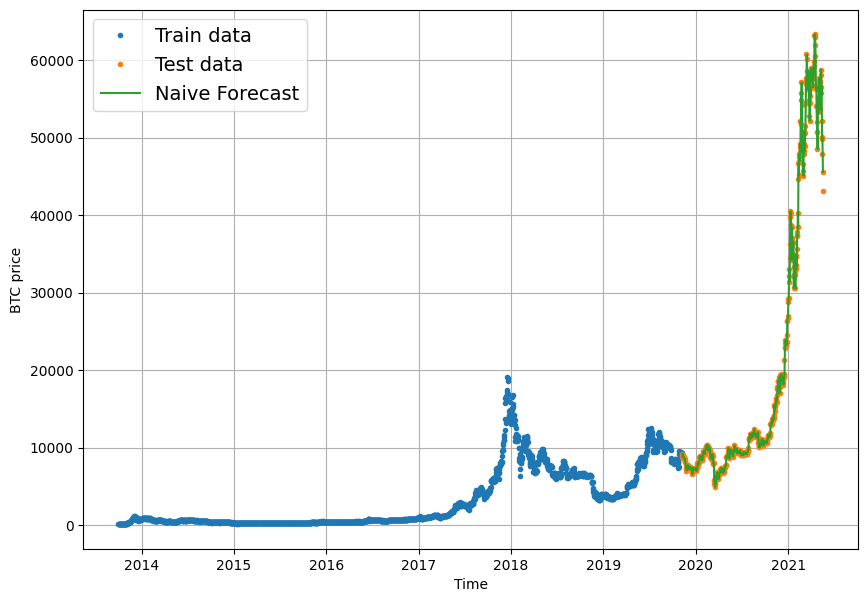

In [14]:
# Plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_time_series(timesteps=X_test,values=y_test,label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

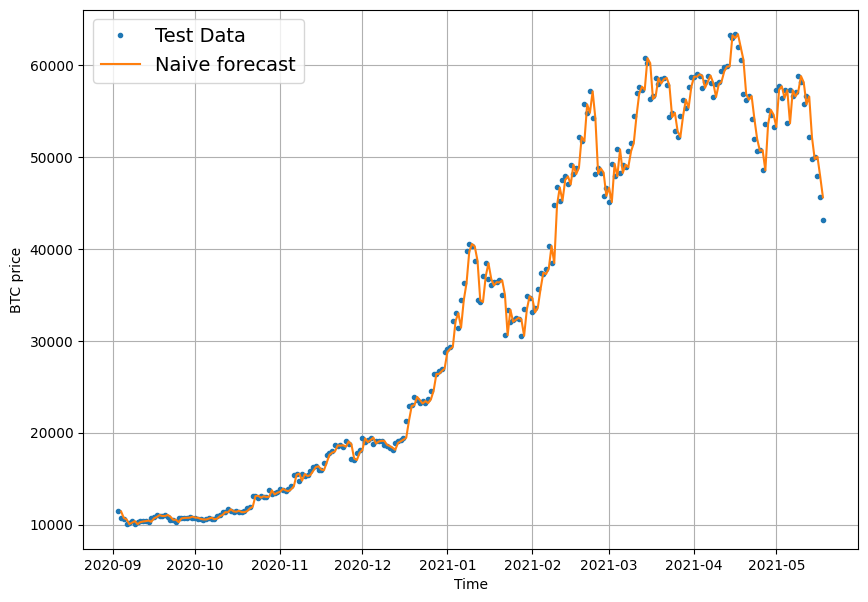

In [15]:
plt.figure(figsize=(10,7))
offset = 300
plot_time_series(timesteps=X_test,values=y_test, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast, format="-", start=offset, label="Naive forecast")

## Evaluate a time series model
Time series forecasting often involves predicting a number.
As the problem statement is about predicting a number, it comes under **regression**
For all the following metrics **lower is better** ( for e.g MAE 0 is better than MAE 100)

### Scale-depdendent errors
These are metrics which can be used to compare time series values and forecast that are on the same scale

Metrics| Details|Code
---|---|---
MAE ( Mean Absolute Error ) | Easy to interpret. Forecast methods which minimizes the <br> MAE will lead to forecasts of the median |`tf.keras.metrics.mean_absolute_error()`
RMSE(Root Mean Squared Error ) | Forecast which minimizes the RMSE lead to forecasts <br> to the mean| `tf.keras.metrics.mean_squared_error()`

### Percentage Errors
Percentage errors do not have units, which mean they can be used to compare forecasts across different units.

Metrics|Details|Code
---|---|---
**MAPE**(Mean Absolute Percentage Error)|Most commonly used percentage error|`tf.keras.metrics.mean_absolute_percentage_error`
**sMAPE**(symmetric Mean Absolute Percentage Error)| Recommend not to use|Custom implementation

### Scaled Errors
Scaled errors are alternative to percentage errors when comparing forecasting performance across different timeseries

Metrics|Details|Code
---|---|---
MASE(mean absolute scaled error)|A forecast which performs better than naive should get <1 MASE|See sktimes<br> `mase_loss()`


In [16]:
import tensorflow as tf


In [17]:
# MASE implemented
def mean_absolute_scaled_error(y_true, y_pred):
  """
    Implement MASE ( assuming no seasonality data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  ## find MAE for naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))

  return mae/mae_naive_no_season

> In practice the naive model should achieve an MASE of 1 (or very close to 1). Any model worse than the naive forecast will achieve an MASE of > 1 and any model better than naive forecast will achieve and MASE of < 1

Let's put each of our different evaluation metrics together into a function

In [18]:
def evaluate_pred(y_true,y_pred):
  #Make sure float32 ( for metric calculation)
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  return {
      "mae": mae.numpy()
      ,"mse": mse.numpy()
      ,"rmse": rmse.numpy()
      ,"mape": mape.numpy()
      ,"mase": mase.numpy()
  }

In [19]:
naive_results= evaluate_pred(y_true=y_test[1:]
                             ,y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Looking at the MAE results, we can infer that on an average the predicted bitcoin price is off from the actual price by about ~567 USD.

## Format Data Part2: Windowing dataset
**Windowing** is a method to turn a time series dataset to _supervised learning problem_.
In other words, we want to use windows of the past to predict the future.
For example, for a univariate time series, windowing for one week(`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

Let's write a function that can take a univariate time series and turn into windows and horizon of specified sizes.

We'll start the default horizon size of 1 and window size of 7


In [20]:
HORIZON= 1 # predict 1 timestep at a time
WINDOW_SIZE= 7 #use a week worth of timesteps to predict the horizon

Now we will write a function that will take an array and return a window and horizon


In [21]:
# Create a function to create labelled window data
def get_labelled_windows(x,horizon=1):
  """
    Creates a label for window dataset
    E.g if horizon=1 (default)
    Input: [1,2,3,4,5,6] -> Output ([1,2,3,4,5],[6])
  """
  return (x[:,:-horizon],x[:, -horizon:])

In [22]:
# Test the window labelling function
test_window, test_label= get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0),horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


#### Make window for the entire timeseries
Let's write a function which:
1. Create a window step of specific window size, for example `[[0,1,2,3,4,5,6]]`
2. Uses [Numpy Indexing]() to create a 2D of multiple window steps, for example
```
[[0,1,2,3,4,5,6,7]
 [1,2,3,4,5,6,7,8]
 [2,3,4,5,6,7,8,9]]
```
3. Uses the 2D array of multiple window steps to index to a target series.
4. Uses the `get_labelled_window` function we created above to turn the window steps into windows with a specified horizon.

In [23]:
import numpy as np

In [24]:
# Create a function to view Numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
   Turns a 1D array into a 2D array of sequential windows of a given window size.
  """
  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step= np.expand_dims(np.arange(window_size+horizon),axis=0)
  # 2. Create a 2D array of multiple window steps
  window_indexes= window_step+ np.expand_dims(np.arange(len(x)- (window_size+horizon-1)),axis=0).T
  # 3. Index on the target array with 2D array of multiple window steps
  windowed_array= x[window_indexes]
  # 4. Get the labelled windows
  windows, labels= get_labelled_windows(windowed_array,horizon=horizon)
  return windows,labels

In [25]:
np.expand_dims(np.arange(7+1),0).T

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [26]:
full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [27]:
## view the first 3 windows/labels
for i in range(3):
  print(f" Window: {full_windows[i]}, Label: {full_labels[i]}")

 Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], Label: [123.033]
 Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], Label: [124.049]
 Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], Label: [125.96116]


We can use tensorflow inbuilt functions to achieve the same output. We need to use `tf.keras.preprocessing.timeseries_dataset_from_array()`

TODO: We will look into this later.

### Turning windows into training and test set
Let's write a function that takes a full set of windows and their labels and splits them into train & test splits.

In [28]:
# Make the train/test split
def make_train_test_split(windows,labels,test_split=0.2):
  """
    Splits matching pairs of windows and labels into train and test split.

  """
  split_size= int(len(windows) * (1-test_split))

  train_windows= windows[:split_size]
  train_labels= labels[:split_size]
  test_windows= windows[split_size:]
  test_labels= labels[split_size:]

  return train_windows, train_labels, test_windows,test_labels


In [29]:
train_windows, train_labels, test_windows,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows), len(test_windows),  len(train_labels),len(test_labels)


(2224, 556, 2224, 556)

In [30]:
train_windows[:5],train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Making a model checkpoint
The `ModelCheckpoint` callback will monitor our model performance during the training and saves the best model to the file system by setting `save_best_only=True`

In [31]:
import os
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name)
                                            ,verbose=0
                                            ,save_best_only=True)

## Model 1: Dense Model ( window = 7, horizon = 1)
Time to build one of our models

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU activation unit.
* An output layer with linear activation.
* Adam optimizer with MAE loss
* Batch size of 128
* 100 epochs

In [32]:
import tensorflow as tf
from tensorflow.keras import layers

## set seed
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation=tf.keras.activations.relu)
    ,layers.Dense(HORIZON,activation=tf.keras.activations.linear)
],name="model_1_dense")

model_1.compile(loss=tf.keras.losses.mean_absolute_error
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"]
                )

history_1= model_1.fit(x=train_windows
                       ,y=train_labels
                       ,epochs=100
                       ,verbose=1
                       ,batch_size=128
                       ,validation_data=(test_windows,test_labels)
                       ,callbacks=[create_model_checkpoint(model_name=model_1.name)]
                       )



Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 3119.9148 - mae: 3119.9148  

18/18 [==============================] - 9s 80ms/step - loss: 2474.8938 - mae: 2474.8938 - val_loss: 4693.1689 - val_mae: 4693.1689
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 391.9913 - mae: 391.9913

18/18 [==============================] - 1s 55ms/step - loss: 391.9669 - mae: 391.9669 - val_loss: 1158.9851 - val_mae: 1158.9851
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 237.3890 - mae: 237.3890 - val_loss: 1189.4362 - val_mae: 1189.4362
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 220.4588 - mae: 220.4588

18/18 [==============================] - 1s 55ms/step - loss: 213.5859 - mae: 213.5859 - val_loss: 1143.8274 - val_mae: 1143.8274
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 227.3166 - mae: 227.3166

18/18 [==============================] - 1s 75ms/step - loss: 202.5035 - mae: 202.5035 - val_loss: 1111.7921 - val_mae: 1111.7921
Epoch 6/100
18/18 [==============================] - 0s 21ms/step - loss: 203.4056 - mae: 203.4056 - val_loss: 1115.6945 - val_mae: 1115.6945
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 200.0759 - mae: 200.0759

18/18 [==============================] - 2s 138ms/step - loss: 199.4317 - mae: 199.4317 - val_loss: 1076.7581 - val_mae: 1076.7581
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 188.4368 - mae: 188.4368

18/18 [==============================] - 1s 67ms/step - loss: 190.4314 - mae: 190.4314 - val_loss: 1060.6055 - val_mae: 1060.6055
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 187.7693 - mae: 187.7693

18/18 [==============================] - 1s 70ms/step - loss: 187.7693 - mae: 187.7693 - val_loss: 1058.0078 - val_mae: 1058.0078
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 179.6338 - mae: 179.6338

18/18 [==============================] - 1s 69ms/step - loss: 183.6759 - mae: 183.6759 - val_loss: 1034.2361 - val_mae: 1034.2361
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 207.6702 - mae: 207.6702

18/18 [==============================] - 1s 71ms/step - loss: 180.1844 - mae: 180.1844 - val_loss: 996.8539 - val_mae: 996.8539
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 180.4889 - mae: 180.4889 - val_loss: 1007.9096 - val_mae: 1007.9096
Epoch 13/100
18/18 [==============================] - 0s 17ms/step - loss: 174.4412 - mae: 174.4412 - val_loss: 1014.7676 - val_mae: 1014.7676
Epoch 14/100
13/18 [====================>.........] - ETA: 0s - loss: 166.2525 - mae: 166.2525

18/18 [==============================] - 1s 47ms/step - loss: 168.9922 - mae: 168.9922 - val_loss: 969.7894 - val_mae: 969.7892
Epoch 15/100
10/18 [===============>..............] - ETA: 0s - loss: 166.0409 - mae: 166.0409

18/18 [==============================] - 1s 51ms/step - loss: 168.4707 - mae: 168.4707 - val_loss: 934.4990 - val_mae: 934.4990
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 161.2919 - mae: 161.2919

18/18 [==============================] - 1s 46ms/step - loss: 161.2919 - mae: 161.2919 - val_loss: 903.2578 - val_mae: 903.2578
Epoch 17/100
18/18 [==============================] - 0s 14ms/step - loss: 157.3325 - mae: 157.3325 - val_loss: 951.6493 - val_mae: 951.6493
Epoch 18/100
18/18 [==============================] - 0s 9ms/step - loss: 155.0747 - mae: 155.0747 - val_loss: 907.8203 - val_mae: 907.8203
Epoch 19/100
10/18 [===============>..............] - ETA: 0s - loss: 149.4917 - mae: 149.4917

18/18 [==============================] - 2s 88ms/step - loss: 150.4001 - mae: 150.4001 - val_loss: 876.0443 - val_mae: 876.0443
Epoch 20/100
13/18 [====================>.........] - ETA: 0s - loss: 152.8131 - mae: 152.8131

18/18 [==============================] - 2s 111ms/step - loss: 149.6752 - mae: 149.6752 - val_loss: 839.1474 - val_mae: 839.1474
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 145.8477 - mae: 145.8477

18/18 [==============================] - 2s 123ms/step - loss: 145.8477 - mae: 145.8477 - val_loss: 787.6827 - val_mae: 787.6827
Epoch 22/100
18/18 [==============================] - 0s 13ms/step - loss: 141.7988 - mae: 141.7988 - val_loss: 799.2583 - val_mae: 799.2583
Epoch 23/100
14/18 [======================>.......] - ETA: 0s - loss: 134.0754 - mae: 134.0754

18/18 [==============================] - 1s 54ms/step - loss: 136.9160 - mae: 136.9160 - val_loss: 775.0152 - val_mae: 775.0152
Epoch 24/100
18/18 [==============================] - 0s 10ms/step - loss: 136.5735 - mae: 136.5735 - val_loss: 790.7350 - val_mae: 790.7350
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 138.7769 - mae: 138.7769

18/18 [==============================] - 1s 60ms/step - loss: 132.8806 - mae: 132.8806 - val_loss: 759.7278 - val_mae: 759.7278
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 133.3266 - mae: 133.3266

18/18 [==============================] - 1s 52ms/step - loss: 129.0381 - mae: 129.0381 - val_loss: 712.7974 - val_mae: 712.7974
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 131.7707 - mae: 131.7707

18/18 [==============================] - 1s 60ms/step - loss: 126.6497 - mae: 126.6497 - val_loss: 699.0728 - val_mae: 699.0728
Epoch 28/100
 9/18 [==============>...............] - ETA: 0s - loss: 131.6290 - mae: 131.6290

18/18 [==============================] - 1s 65ms/step - loss: 123.8828 - mae: 123.8828 - val_loss: 689.1431 - val_mae: 689.1431
Epoch 29/100
12/18 [===================>..........] - ETA: 0s - loss: 123.7934 - mae: 123.7934

18/18 [==============================] - 1s 62ms/step - loss: 122.4630 - mae: 122.4630 - val_loss: 675.1374 - val_mae: 675.1374
Epoch 30/100
18/18 [==============================] - 0s 11ms/step - loss: 124.4024 - mae: 124.4024 - val_loss: 678.9478 - val_mae: 678.9478
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 121.2907 - mae: 121.2907 - val_loss: 694.1503 - val_mae: 694.1503
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 114.2192 - mae: 114.2192

18/18 [==============================] - 1s 56ms/step - loss: 121.6552 - mae: 121.6552 - val_loss: 661.8483 - val_mae: 661.8483
Epoch 33/100
18/18 [==============================] - 0s 13ms/step - loss: 117.4547 - mae: 117.4547 - val_loss: 720.2442 - val_mae: 720.2442
Epoch 34/100
 9/18 [==============>...............] - ETA: 0s - loss: 120.5814 - mae: 120.5814

18/18 [==============================] - 1s 41ms/step - loss: 120.6764 - mae: 120.6764 - val_loss: 657.6562 - val_mae: 657.6562
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 102.3403 - mae: 102.3403

18/18 [==============================] - 2s 115ms/step - loss: 118.0150 - mae: 118.0150 - val_loss: 639.0272 - val_mae: 639.0272
Epoch 36/100
18/18 [==============================] - 0s 14ms/step - loss: 120.7231 - mae: 120.7231 - val_loss: 646.7753 - val_mae: 646.7753
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 119.6344 - mae: 119.6344

18/18 [==============================] - 1s 72ms/step - loss: 120.3193 - mae: 120.3193 - val_loss: 621.0537 - val_mae: 621.0537
Epoch 38/100
 6/18 [=========>....................] - ETA: 0s - loss: 130.7545 - mae: 130.7545

18/18 [==============================] - 1s 50ms/step - loss: 114.7086 - mae: 114.7086 - val_loss: 615.2505 - val_mae: 615.2505
Epoch 39/100
18/18 [==============================] - 0s 9ms/step - loss: 112.7777 - mae: 112.7777 - val_loss: 624.3047 - val_mae: 624.3047
Epoch 40/100
11/18 [=================>............] - ETA: 0s - loss: 111.1641 - mae: 111.1641

18/18 [==============================] - 1s 61ms/step - loss: 111.8383 - mae: 111.8383 - val_loss: 609.1974 - val_mae: 609.1974
Epoch 41/100
18/18 [==============================] - 0s 12ms/step - loss: 112.2642 - mae: 112.2642 - val_loss: 628.9989 - val_mae: 628.9989
Epoch 42/100
12/18 [===================>..........] - ETA: 0s - loss: 114.9758 - mae: 114.9758

18/18 [==============================] - 1s 52ms/step - loss: 118.2435 - mae: 118.2435 - val_loss: 605.3145 - val_mae: 605.3145
Epoch 43/100
18/18 [==============================] - 0s 9ms/step - loss: 112.7992 - mae: 112.7992 - val_loss: 633.1926 - val_mae: 633.1926
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 110.5124 - mae: 110.5124

18/18 [==============================] - 1s 63ms/step - loss: 113.9353 - mae: 113.9353 - val_loss: 597.9756 - val_mae: 597.9756
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7181 - mae: 110.7181 - val_loss: 599.2021 - val_mae: 599.2021
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 84.7308 - mae: 84.7308

18/18 [==============================] - 1s 30ms/step - loss: 112.6162 - mae: 112.6162 - val_loss: 596.1751 - val_mae: 596.1751
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9526 - mae: 111.9526 - val_loss: 697.6033 - val_mae: 697.6033
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7492 - mae: 111.7492 - val_loss: 602.2405 - val_mae: 602.2405
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1467 - mae: 111.1467 - val_loss: 626.2000 - val_mae: 626.2000
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 114.5612 - mae: 114.5612 - val_loss: 597.9068 - val_mae: 597.9068
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 85.7857 - mae: 85.7857

18/18 [==============================] - 1s 29ms/step - loss: 110.5712 - mae: 110.5712 - val_loss: 590.8340 - val_mae: 590.8340
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9458 - mae: 113.9458 - val_loss: 623.4016 - val_mae: 623.4016
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 110.9170 - mae: 110.9170 - val_loss: 611.2315 - val_mae: 611.2315
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4080 - mae: 110.4080 - val_loss: 590.8555 - val_mae: 590.8555
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 127.6813 - mae: 127.6813

18/18 [==============================] - 1s 29ms/step - loss: 113.4899 - mae: 113.4899 - val_loss: 587.0169 - val_mae: 587.0169
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6605 - mae: 111.6605 - val_loss: 687.5815 - val_mae: 687.5816
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 120.2608 - mae: 120.2608 - val_loss: 640.7870 - val_mae: 640.7870
Epoch 58/100
 1/18 [>.............................] - ETA: 0s - loss: 93.0968 - mae: 93.0968

18/18 [==============================] - 1s 31ms/step - loss: 117.6212 - mae: 117.6212 - val_loss: 584.0880 - val_mae: 584.0880
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 80.4016 - mae: 80.4016

18/18 [==============================] - 1s 31ms/step - loss: 110.1385 - mae: 110.1385 - val_loss: 583.6204 - val_mae: 583.6204
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9846 - mae: 108.9846 - val_loss: 621.3847 - val_mae: 621.3847
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3219 - mae: 110.3219 - val_loss: 585.4926 - val_mae: 585.4926
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7141 - mae: 109.7141 - val_loss: 633.1057 - val_mae: 633.1057
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 114.3262 - mae: 114.3262 - val_loss: 612.2175 - val_mae: 612.2175
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2383 - mae: 111.2383 - val_loss: 679.5093 - val_mae: 679.5093
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 146.0591 - mae: 146.0591

18/18 [==============================] - 1s 30ms/step - loss: 111.3693 - mae: 111.3693 - val_loss: 581.4755 - val_mae: 581.4755
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5430 - mae: 108.5430 - val_loss: 582.2659 - val_mae: 582.2659
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6163 - mae: 107.6163 - val_loss: 712.2000 - val_mae: 712.2000
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 117.5700 - mae: 117.5700 - val_loss: 738.3881 - val_mae: 738.3881
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 128.3785 - mae: 128.3785 - val_loss: 622.3885 - val_mae: 622.3885
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 122.6918 - mae: 122.6918 - val_loss: 595.6204 - val_mae: 595.6204
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 109.8377 - mae: 109.8377 - val_loss: 598.0516 - val_mae: 598.0516
Epoch 72/100
18/18 [============

18/18 [==============================] - 1s 46ms/step - loss: 107.1393 - mae: 107.1393 - val_loss: 578.1879 - val_mae: 578.1879
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 109.1462 - mae: 109.1462 - val_loss: 595.1381 - val_mae: 595.1381
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 109.1453 - mae: 109.1453 - val_loss: 587.0237 - val_mae: 587.0237
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 110.2856 - mae: 110.2856 - val_loss: 600.4637 - val_mae: 600.4637
Epoch 78/100
13/18 [====================>.........] - ETA: 0s - loss: 103.7996 - mae: 103.7996

18/18 [==============================] - 1s 41ms/step - loss: 106.9266 - mae: 106.9266 - val_loss: 575.7059 - val_mae: 575.7059
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3470 - mae: 107.3470 - val_loss: 584.4290 - val_mae: 584.4290
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5685 - mae: 107.5685 - val_loss: 596.0263 - val_mae: 596.0263
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 95.1098 - mae: 95.1098

18/18 [==============================] - 1s 41ms/step - loss: 107.2264 - mae: 107.2264 - val_loss: 574.7416 - val_mae: 574.7416
Epoch 82/100
18/18 [==============================] - 0s 10ms/step - loss: 115.9805 - mae: 115.9805 - val_loss: 582.1184 - val_mae: 582.1184
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 110.5089 - mae: 110.5089 - val_loss: 627.0969 - val_mae: 627.0969
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 110.9411 - mae: 110.9411 - val_loss: 582.0397 - val_mae: 582.0397
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 106.7979 - mae: 106.7979 - val_loss: 580.8143 - val_mae: 580.8143
Epoch 86/100
18/18 [==============================] - 0s 10ms/step - loss: 107.1578 - mae: 107.1578 - val_loss: 588.9248 - val_mae: 588.9248
Epoch 87/100
18/18 [==============================] - 0s 10ms/step - loss: 106.2695 - mae: 106.2695 - val_loss: 601.0750 - val_mae: 601.0750
Epoch 88/100
18/18 [========

18/18 [==============================] - 1s 79ms/step - loss: 107.4067 - mae: 107.4067 - val_loss: 574.3358 - val_mae: 574.3358
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 106.8240 - mae: 106.8240 - val_loss: 605.1922 - val_mae: 605.1922
Epoch 91/100
13/18 [====================>.........] - ETA: 0s - loss: 105.8419 - mae: 105.8419

18/18 [==============================] - 1s 44ms/step - loss: 108.9456 - mae: 108.9456 - val_loss: 573.5940 - val_mae: 573.5940
Epoch 92/100
14/18 [======================>.......] - ETA: 0s - loss: 109.1038 - mae: 109.1038

18/18 [==============================] - 1s 53ms/step - loss: 108.7275 - mae: 108.7275 - val_loss: 573.0451 - val_mae: 573.0451
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 113.2202 - mae: 113.2202 - val_loss: 615.1943 - val_mae: 615.1943
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9992 - mae: 109.9992 - val_loss: 591.7327 - val_mae: 591.7327
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 106.3771 - mae: 106.3771 - val_loss: 580.6734 - val_mae: 580.6734
Epoch 96/100
18/18 [==============================] - 0s 9ms/step - loss: 108.5869 - mae: 108.5869 - val_loss: 621.3984 - val_mae: 621.3984
Epoch 97/100
18/18 [==============================] - 0s 9ms/step - loss: 108.7144 - mae: 108.7144 - val_loss: 594.6421 - val_mae: 594.6421
Epoch 98/100
18/18 [==============================] - 0s 8ms/step - loss: 107.3033 - mae: 107.3033 - val_loss: 575.5452 - val_mae: 575.5452
Epoch 99/100
13/18 [============

18/18 [==============================] - 1s 42ms/step - loss: 108.1777 - mae: 108.1777 - val_loss: 571.7001 - val_mae: 571.7001
Epoch 100/100
18/18 [==============================] - 0s 9ms/step - loss: 107.5492 - mae: 107.5492 - val_loss: 596.2319 - val_mae: 596.2319


In [33]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 596.2319 - mae: 596.2319


[596.2318725585938, 596.2318725585938]

In [34]:
# Load in best saved model and evaluate on test data
saved_model_1 = tf.keras.models.load_model("model_experiment/model_1_dense")
saved_model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 571.7000 - mae: 571.7000


[571.7000122070312, 571.7000122070312]

## Making forecast with a model ( on test dataset )
Since we are going to run more modelling experiments, lets write a function which can return the predictions given a model and input data

* Take a trained model
* Take in some input data
* Pass the input data to the model
* Returns the prediction

In [35]:
def make_preds(model,input_data):
  """
    Uses model to make predictions on input data

    Args:
      model: trained model
      input_data: windowed input data ( same kind as the model is trained on)
    Returns:
      model prediction on input data
  """
  return tf.squeeze(model.predict(input_data))

In [36]:
model_1_preds = make_preds(model_1,test_windows)
model_1_preds[:10], len(model_1_preds)

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8794.736 , 8700.321 , 8987.522 , 8717.64  , 8634.877 , 8706.923 ,
        8624.287 , 8432.216 , 8410.5625, 8467.961 ], dtype=float32)>,
 556)

### Now lets evaluate our model using the `evaluate_model` method we create above in this notebook

In [37]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [38]:
evaluate_pred?

In [39]:
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels)
                                ,y_pred=model_1_preds)
model_1_results

{'mae': 596.2318,
 'mse': 1220747.2,
 'rmse': 1104.8743,
 'mape': 2.6514933,
 'mase': 1.0474142}

### Let us use the `plot_time_series` function to plot the `model_1_preds` against the test_data

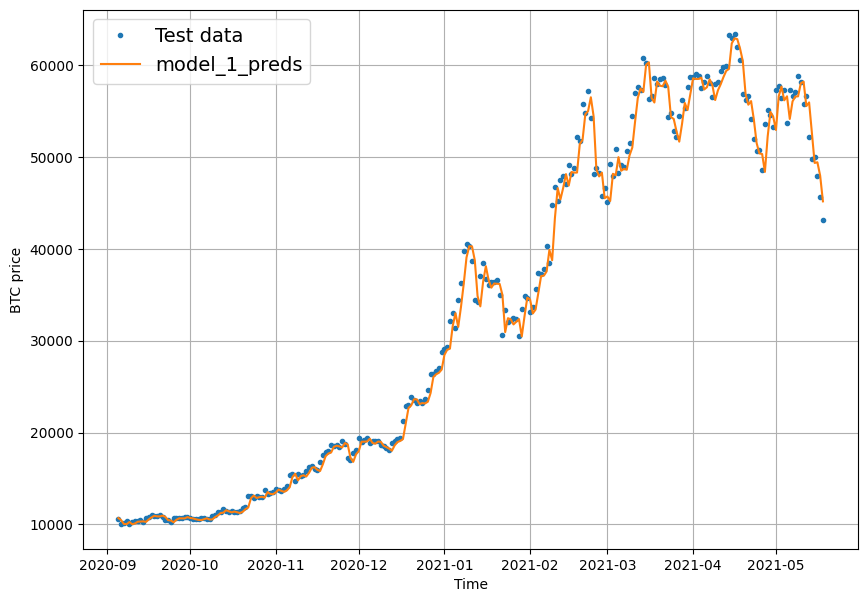

In [40]:
offset= 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds
                 ,start=offset,label="model_1_preds",format="-")


## Model 2: Window size=30, Horizon=1
We will start with our second modelling experiment where the window size=30 and horizon=1

We will use the functions we have created earlier to create our train/test feature and train/test labels


In [41]:
HORIZON=1
WINDOW_SIZE=30

In [42]:
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE
                                         ,horizon=HORIZON)

len(full_windows), len(full_labels)

(2757, 2757)

In [43]:
train_window, train_label, test_window , test_label=make_train_test_split(full_windows
                                                                         ,full_labels
                                                                         ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)


(2205, 2205, 552, 552)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# set seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_2_Dense")

model_2.compile(loss="mae"
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["mae"]
                 )
history_2 = model_2.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_2.name)])





Epoch 1/100
61/69 [=========================>....] - ETA: 0s - loss: 499.1999 - mae: 499.1999

69/69 [==============================] - 4s 27ms/step - loss: 476.2355 - mae: 476.2355 - val_loss: 1632.4976 - val_mae: 1632.4976
Epoch 2/100
69/69 [==============================] - 0s 4ms/step - loss: 257.1349 - mae: 257.1349 - val_loss: 2029.1934 - val_mae: 2029.1934
Epoch 3/100
55/69 [======================>.......] - ETA: 0s - loss: 288.7770 - mae: 288.7770

69/69 [==============================] - 1s 10ms/step - loss: 270.0990 - mae: 270.0990 - val_loss: 1085.1206 - val_mae: 1085.1206
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 200.7354 - mae: 200.7354 - val_loss: 1087.7996 - val_mae: 1087.7996
Epoch 5/100
58/69 [========================>.....] - ETA: 0s - loss: 177.7808 - mae: 177.7808

69/69 [==============================] - 1s 10ms/step - loss: 177.6009 - mae: 177.6009 - val_loss: 902.5558 - val_mae: 902.5558
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 179.5687 - mae: 179.5687 - val_loss: 913.0562 - val_mae: 913.0562
Epoch 7/100
69/69 [==============================] - 0s 4ms/step - loss: 193.1787 - mae: 193.1787 - val_loss: 1569.5507 - val_mae: 1569.5507
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 186.6747 - mae: 186.6747 - val_loss: 1008.5926 - val_mae: 1008.5926
Epoch 9/100
69/69 [==============================] - 0s 3ms/step - loss: 208.6494 - mae: 208.6494 - val_loss: 1233.5732 - val_mae: 1233.5732
Epoch 10/100
53/69 [======================>.......] - ETA: 0s - loss: 179.9966 - mae: 179.9966

69/69 [==============================] - 1s 12ms/step - loss: 178.2922 - mae: 178.2922 - val_loss: 879.0799 - val_mae: 879.0799
Epoch 11/100
69/69 [==============================] - 1s 8ms/step - loss: 171.6047 - mae: 171.6047 - val_loss: 960.7001 - val_mae: 960.7001
Epoch 12/100
69/69 [==============================] - 0s 5ms/step - loss: 175.5034 - mae: 175.5034 - val_loss: 1031.6769 - val_mae: 1031.6769
Epoch 13/100
57/69 [=======================>......] - ETA: 0s - loss: 183.8461 - mae: 183.8461

69/69 [==============================] - 1s 12ms/step - loss: 180.7123 - mae: 180.7123 - val_loss: 770.4318 - val_mae: 770.4318
Epoch 14/100
69/69 [==============================] - 0s 3ms/step - loss: 145.8467 - mae: 145.8467 - val_loss: 914.5248 - val_mae: 914.5248
Epoch 15/100
69/69 [==============================] - 0s 4ms/step - loss: 146.9620 - mae: 146.9620 - val_loss: 783.6486 - val_mae: 783.6486
Epoch 16/100
69/69 [==============================] - 0s 4ms/step - loss: 154.0614 - mae: 154.0614 - val_loss: 1077.6152 - val_mae: 1077.6152
Epoch 17/100
69/69 [==============================] - 0s 4ms/step - loss: 184.2703 - mae: 184.2703 - val_loss: 801.5911 - val_mae: 801.5911
Epoch 18/100
58/69 [========================>.....] - ETA: 0s - loss: 141.1131 - mae: 141.1131

69/69 [==============================] - 1s 10ms/step - loss: 142.0281 - mae: 142.0281 - val_loss: 725.8480 - val_mae: 725.8480
Epoch 19/100
69/69 [==============================] - 0s 3ms/step - loss: 163.4479 - mae: 163.4479 - val_loss: 1271.6443 - val_mae: 1271.6443
Epoch 20/100
69/69 [==============================] - 0s 4ms/step - loss: 164.4186 - mae: 164.4186 - val_loss: 855.8304 - val_mae: 855.8304
Epoch 21/100
69/69 [==============================] - 0s 4ms/step - loss: 140.7743 - mae: 140.7743 - val_loss: 788.5804 - val_mae: 788.5804
Epoch 22/100
57/69 [=======================>......] - ETA: 0s - loss: 134.5434 - mae: 134.5434

69/69 [==============================] - 1s 10ms/step - loss: 135.9147 - mae: 135.9147 - val_loss: 668.8672 - val_mae: 668.8672
Epoch 23/100
69/69 [==============================] - 0s 4ms/step - loss: 159.6143 - mae: 159.6143 - val_loss: 2303.6785 - val_mae: 2303.6785
Epoch 24/100
69/69 [==============================] - 0s 5ms/step - loss: 187.8191 - mae: 187.8191 - val_loss: 848.4772 - val_mae: 848.4772
Epoch 25/100
69/69 [==============================] - 0s 5ms/step - loss: 146.6131 - mae: 146.6131 - val_loss: 809.0403 - val_mae: 809.0403
Epoch 26/100
69/69 [==============================] - 0s 5ms/step - loss: 157.4892 - mae: 157.4892 - val_loss: 779.7370 - val_mae: 779.7370
Epoch 27/100
69/69 [==============================] - 0s 5ms/step - loss: 150.9109 - mae: 150.9109 - val_loss: 757.2491 - val_mae: 757.2491
Epoch 28/100
62/69 [=========================>....] - ETA: 0s - loss: 150.1985 - mae: 150.1985

69/69 [==============================] - 1s 14ms/step - loss: 147.6553 - mae: 147.6553 - val_loss: 650.6548 - val_mae: 650.6548
Epoch 29/100
58/69 [========================>.....] - ETA: 0s - loss: 128.7470 - mae: 128.7470

69/69 [==============================] - 1s 15ms/step - loss: 131.7292 - mae: 131.7292 - val_loss: 643.3257 - val_mae: 643.3257
Epoch 30/100
69/69 [==============================] - 0s 4ms/step - loss: 171.3372 - mae: 171.3372 - val_loss: 1214.1909 - val_mae: 1214.1909
Epoch 31/100
69/69 [==============================] - 0s 3ms/step - loss: 130.8551 - mae: 130.8551 - val_loss: 649.3912 - val_mae: 649.3912
Epoch 32/100
69/69 [==============================] - 0s 4ms/step - loss: 144.4658 - mae: 144.4658 - val_loss: 814.4922 - val_mae: 814.4922
Epoch 33/100
69/69 [==============================] - 0s 3ms/step - loss: 126.8258 - mae: 126.8258 - val_loss: 1134.7242 - val_mae: 1134.7242
Epoch 34/100
69/69 [==============================] - 0s 4ms/step - loss: 193.2783 - mae: 193.2783 - val_loss: 884.5269 - val_mae: 884.5269
Epoch 35/100
69/69 [==============================] - 0s 4ms/step - loss: 132.4526 - mae: 132.4526 - val_loss: 766.5671 - val_mae: 766.5671
Epoch 36/100
69/69 [========

69/69 [==============================] - 1s 10ms/step - loss: 131.9890 - mae: 131.9890 - val_loss: 624.6299 - val_mae: 624.6299
Epoch 40/100
69/69 [==============================] - 0s 4ms/step - loss: 150.3968 - mae: 150.3968 - val_loss: 756.5433 - val_mae: 756.5433
Epoch 41/100
69/69 [==============================] - 0s 3ms/step - loss: 128.8337 - mae: 128.8337 - val_loss: 1030.2180 - val_mae: 1030.2180
Epoch 42/100
69/69 [==============================] - 0s 4ms/step - loss: 137.5561 - mae: 137.5561 - val_loss: 673.0781 - val_mae: 673.0781
Epoch 43/100
51/69 [=====================>........] - ETA: 0s - loss: 146.0859 - mae: 146.0859

69/69 [==============================] - 1s 10ms/step - loss: 137.3330 - mae: 137.3330 - val_loss: 618.9949 - val_mae: 618.9949
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 141.6258 - mae: 141.6258 - val_loss: 776.8821 - val_mae: 776.8821
Epoch 45/100
69/69 [==============================] - 0s 4ms/step - loss: 127.2959 - mae: 127.2959 - val_loss: 655.5589 - val_mae: 655.5589
Epoch 46/100
69/69 [==============================] - 0s 4ms/step - loss: 147.6964 - mae: 147.6964 - val_loss: 621.4299 - val_mae: 621.4299
Epoch 47/100
69/69 [==============================] - 0s 3ms/step - loss: 130.4187 - mae: 130.4187 - val_loss: 1329.8066 - val_mae: 1329.8066
Epoch 48/100
69/69 [==============================] - 0s 4ms/step - loss: 168.4618 - mae: 168.4618 - val_loss: 666.0176 - val_mae: 666.0176
Epoch 49/100
69/69 [==============================] - 0s 4ms/step - loss: 138.4957 - mae: 138.4957 - val_loss: 647.7224 - val_mae: 647.7224
Epoch 50/100
69/69 [==========

69/69 [==============================] - 1s 11ms/step - loss: 128.8190 - mae: 128.8190 - val_loss: 611.4984 - val_mae: 611.4984
Epoch 53/100
69/69 [==============================] - 0s 4ms/step - loss: 143.9510 - mae: 143.9510 - val_loss: 881.6825 - val_mae: 881.6825
Epoch 54/100
69/69 [==============================] - 0s 4ms/step - loss: 125.0510 - mae: 125.0510 - val_loss: 685.9076 - val_mae: 685.9076
Epoch 55/100
69/69 [==============================] - 0s 4ms/step - loss: 121.4784 - mae: 121.4784 - val_loss: 652.3171 - val_mae: 652.3171
Epoch 56/100
69/69 [==============================] - 0s 4ms/step - loss: 161.5749 - mae: 161.5749 - val_loss: 618.2188 - val_mae: 618.2188
Epoch 57/100
69/69 [==============================] - 0s 4ms/step - loss: 147.2603 - mae: 147.2603 - val_loss: 856.4584 - val_mae: 856.4584
Epoch 58/100
69/69 [==============================] - 0s 5ms/step - loss: 142.8620 - mae: 142.8620 - val_loss: 658.0791 - val_mae: 658.0791
Epoch 59/100
69/69 [============

69/69 [==============================] - 1s 18ms/step - loss: 136.6558 - mae: 136.6558 - val_loss: 604.7435 - val_mae: 604.7435
Epoch 63/100
69/69 [==============================] - 0s 5ms/step - loss: 130.3778 - mae: 130.3778 - val_loss: 615.3881 - val_mae: 615.3881
Epoch 64/100
69/69 [==============================] - 0s 7ms/step - loss: 143.4695 - mae: 143.4695 - val_loss: 905.7433 - val_mae: 905.7433
Epoch 65/100
69/69 [==============================] - 0s 6ms/step - loss: 127.4809 - mae: 127.4809 - val_loss: 612.2792 - val_mae: 612.2792
Epoch 66/100
69/69 [==============================] - 0s 4ms/step - loss: 150.9658 - mae: 150.9658 - val_loss: 988.2472 - val_mae: 988.2472
Epoch 67/100
69/69 [==============================] - 0s 5ms/step - loss: 137.6287 - mae: 137.6287 - val_loss: 752.8150 - val_mae: 752.8150
Epoch 68/100
69/69 [==============================] - 0s 5ms/step - loss: 126.5323 - mae: 126.5323 - val_loss: 829.8335 - val_mae: 829.8335
Epoch 69/100
51/69 [============

69/69 [==============================] - 1s 14ms/step - loss: 160.9986 - mae: 160.9986 - val_loss: 598.5658 - val_mae: 598.5658
Epoch 70/100
69/69 [==============================] - 0s 5ms/step - loss: 119.4746 - mae: 119.4746 - val_loss: 789.5904 - val_mae: 789.5904
Epoch 71/100
69/69 [==============================] - 0s 7ms/step - loss: 119.8662 - mae: 119.8662 - val_loss: 650.1426 - val_mae: 650.1426
Epoch 72/100
69/69 [==============================] - 0s 6ms/step - loss: 123.8340 - mae: 123.8340 - val_loss: 986.9015 - val_mae: 986.9015
Epoch 73/100
69/69 [==============================] - 0s 5ms/step - loss: 136.4302 - mae: 136.4302 - val_loss: 1169.4586 - val_mae: 1169.4586
Epoch 74/100
69/69 [==============================] - 0s 5ms/step - loss: 131.0624 - mae: 131.0624 - val_loss: 860.6323 - val_mae: 860.6323
Epoch 75/100
69/69 [==============================] - 0s 6ms/step - loss: 131.7955 - mae: 131.7955 - val_loss: 1544.3643 - val_mae: 1544.3643
Epoch 76/100
69/69 [========

69/69 [==============================] - 1s 15ms/step - loss: 122.8306 - mae: 122.8306 - val_loss: 587.4337 - val_mae: 587.4337
Epoch 83/100
69/69 [==============================] - 0s 6ms/step - loss: 125.1678 - mae: 125.1678 - val_loss: 1044.8739 - val_mae: 1044.8739
Epoch 84/100
69/69 [==============================] - 1s 8ms/step - loss: 128.0998 - mae: 128.0998 - val_loss: 733.3141 - val_mae: 733.3141
Epoch 85/100
69/69 [==============================] - 1s 8ms/step - loss: 120.4767 - mae: 120.4767 - val_loss: 634.2354 - val_mae: 634.2354
Epoch 86/100
69/69 [==============================] - 1s 8ms/step - loss: 144.7122 - mae: 144.7122 - val_loss: 679.2128 - val_mae: 679.2128
Epoch 87/100
69/69 [==============================] - 0s 6ms/step - loss: 139.5948 - mae: 139.5948 - val_loss: 900.5421 - val_mae: 900.5421
Epoch 88/100
69/69 [==============================] - 0s 5ms/step - loss: 137.2974 - mae: 137.2974 - val_loss: 664.0985 - val_mae: 664.0985
Epoch 89/100
69/69 [==========

69/69 [==============================] - 1s 10ms/step - loss: 111.2066 - mae: 111.2066 - val_loss: 584.7877 - val_mae: 584.7877
Epoch 94/100
69/69 [==============================] - 0s 4ms/step - loss: 154.3544 - mae: 154.3544 - val_loss: 598.0330 - val_mae: 598.0330
Epoch 95/100
69/69 [==============================] - 0s 4ms/step - loss: 124.5940 - mae: 124.5940 - val_loss: 1049.6213 - val_mae: 1049.6213
Epoch 96/100
69/69 [==============================] - 0s 4ms/step - loss: 121.5540 - mae: 121.5540 - val_loss: 620.3879 - val_mae: 620.3879
Epoch 97/100
69/69 [==============================] - 0s 4ms/step - loss: 138.4108 - mae: 138.4108 - val_loss: 594.0101 - val_mae: 594.0101
Epoch 98/100
69/69 [==============================] - 0s 4ms/step - loss: 135.7317 - mae: 135.7317 - val_loss: 661.5496 - val_mae: 661.5496
Epoch 99/100
69/69 [==============================] - 0s 4ms/step - loss: 122.8978 - mae: 122.8978 - val_loss: 613.1983 - val_mae: 613.1983
Epoch 100/100
69/69 [=========

In [45]:
# Evaluate model
model_2.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 1835.9264 - mae: 1835.9264


[1835.9263916015625, 1835.9263916015625]

In [46]:
model_2_preds = make_preds(model_2,test_window)
len(model_2_preds),model_2_preds[:10]

18/18 [==============================] - 0s 2ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([9673.082, 9706.843, 9656.78 , 9468.61 , 9335.96 , 9263.385,
        9119.814, 9132.64 , 9059.272, 8638.523], dtype=float32)>)

In [47]:
model_2_results = evaluate_pred(y_true=tf.squeeze(test_label)
                                ,y_pred=model_2_preds)
model_2_results

{'mae': 1835.9264,
 'mse': 7281724.5,
 'rmse': 2698.467,
 'mape': 9.44132,
 'mase': 3.2092173}

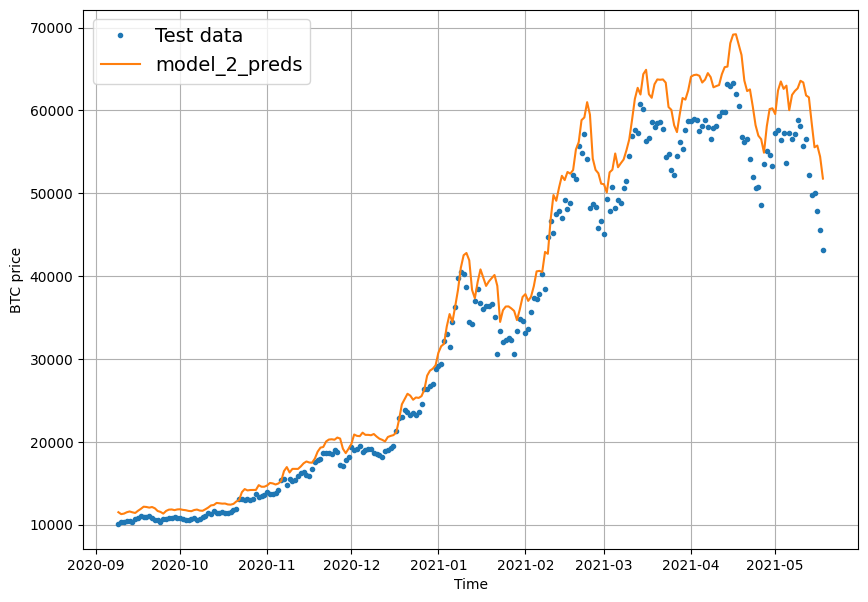

In [48]:
## Lets plot the predictions
offset=300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_window):],values=test_label[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_window):],values=model_2_preds
                 ,start=offset,label="model_2_preds",format="-")

## Model 3: Window size=30, Horizon=7

In [49]:
WINDOW_SIZE=30
HORIZON=7
full_window, full_label = make_windows(prices, window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_window), len(full_label)

(2751, 2751)

In [50]:
train_window, train_label, test_window, test_label = make_train_test_split(windows=full_window, labels=full_label
                                                                           ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)

(2200, 2200, 551, 551)

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
# set random seed
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_3_dense")

model_3.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_3 = model_3.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
64/69 [==========================>...] - ETA: 0s - loss: 666.0872 - mae: 666.0872

69/69 [==============================] - 3s 24ms/step - loss: 646.3141 - mae: 646.3141 - val_loss: 1844.6725 - val_mae: 1844.6725
Epoch 2/100
68/69 [============================>.] - ETA: 0s - loss: 346.0438 - mae: 346.0438

69/69 [==============================] - 2s 28ms/step - loss: 345.8870 - mae: 345.8870 - val_loss: 1723.0177 - val_mae: 1723.0177
Epoch 3/100
67/69 [============================>.] - ETA: 0s - loss: 303.4541 - mae: 303.4541

69/69 [==============================] - 1s 15ms/step - loss: 301.9443 - mae: 301.9443 - val_loss: 1688.5446 - val_mae: 1688.5446
Epoch 4/100
68/69 [============================>.] - ETA: 0s - loss: 287.2436 - mae: 287.2436

69/69 [==============================] - 1s 20ms/step - loss: 286.7459 - mae: 286.7459 - val_loss: 1487.0232 - val_mae: 1487.0232
Epoch 5/100
69/69 [==============================] - 0s 6ms/step - loss: 272.4444 - mae: 272.4444 - val_loss: 1729.9907 - val_mae: 1729.9907
Epoch 6/100
69/69 [==============================] - 1s 9ms/step - loss: 268.1653 - mae: 268.1653 - val_loss: 1741.8818 - val_mae: 1741.8818
Epoch 7/100
66/69 [===========================>..] - ETA: 0s - loss: 273.1353 - mae: 273.1353

69/69 [==============================] - 1s 18ms/step - loss: 271.4835 - mae: 271.4835 - val_loss: 1382.6987 - val_mae: 1382.6987
Epoch 8/100
69/69 [==============================] - 1s 10ms/step - loss: 260.6907 - mae: 260.6907 - val_loss: 1417.7623 - val_mae: 1417.7623
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 253.1796 - mae: 253.1796 - val_loss: 1436.9657 - val_mae: 1436.9657
Epoch 10/100
69/69 [==============================] - 0s 4ms/step - loss: 258.3198 - mae: 258.3198 - val_loss: 1406.5323 - val_mae: 1406.5323
Epoch 11/100
69/69 [==============================] - 0s 4ms/step - loss: 252.6072 - mae: 252.6072 - val_loss: 1400.8920 - val_mae: 1400.8920
Epoch 12/100
58/69 [========================>.....] - ETA: 0s - loss: 248.0176 - mae: 248.0176

69/69 [==============================] - 1s 10ms/step - loss: 253.9075 - mae: 253.9075 - val_loss: 1319.9044 - val_mae: 1319.9044
Epoch 13/100
69/69 [==============================] - 0s 4ms/step - loss: 251.7946 - mae: 251.7946 - val_loss: 1593.3676 - val_mae: 1593.3676
Epoch 14/100
69/69 [==============================] - 0s 4ms/step - loss: 253.4298 - mae: 253.4298 - val_loss: 1522.6926 - val_mae: 1522.6926
Epoch 15/100
69/69 [==============================] - 0s 4ms/step - loss: 248.6073 - mae: 248.6073 - val_loss: 1563.8433 - val_mae: 1563.8433
Epoch 16/100
69/69 [==============================] - 0s 4ms/step - loss: 259.3301 - mae: 259.3301 - val_loss: 1614.0289 - val_mae: 1614.0289
Epoch 17/100
69/69 [==============================] - 0s 4ms/step - loss: 245.9796 - mae: 245.9796 - val_loss: 1410.6403 - val_mae: 1410.6403
Epoch 18/100
69/69 [==============================] - 0s 4ms/step - loss: 242.0439 - mae: 242.0439 - val_loss: 1342.0009 - val_mae: 1342.0009
Epoch 19/100
69/69

69/69 [==============================] - 1s 15ms/step - loss: 244.1435 - mae: 244.1435 - val_loss: 1282.0095 - val_mae: 1282.0095
Epoch 24/100
69/69 [==============================] - 0s 5ms/step - loss: 251.0309 - mae: 251.0309 - val_loss: 1314.8398 - val_mae: 1314.8398
Epoch 25/100
69/69 [==============================] - 0s 5ms/step - loss: 238.6097 - mae: 238.6097 - val_loss: 1360.2278 - val_mae: 1360.2278
Epoch 26/100
69/69 [==============================] - 0s 6ms/step - loss: 239.3182 - mae: 239.3182 - val_loss: 1341.4460 - val_mae: 1341.4460
Epoch 27/100
69/69 [==============================] - 0s 5ms/step - loss: 242.1477 - mae: 242.1477 - val_loss: 1444.3246 - val_mae: 1444.3246
Epoch 28/100
69/69 [==============================] - 0s 6ms/step - loss: 238.6069 - mae: 238.6069 - val_loss: 1331.3702 - val_mae: 1331.3702
Epoch 29/100
61/69 [=========================>....] - ETA: 0s - loss: 235.5182 - mae: 235.5182

69/69 [==============================] - 1s 21ms/step - loss: 237.3247 - mae: 237.3247 - val_loss: 1244.9923 - val_mae: 1244.9923
Epoch 30/100
69/69 [==============================] - 0s 6ms/step - loss: 236.9720 - mae: 236.9720 - val_loss: 1470.7596 - val_mae: 1470.7596
Epoch 31/100
69/69 [==============================] - 0s 4ms/step - loss: 236.0946 - mae: 236.0946 - val_loss: 1261.2820 - val_mae: 1261.2820
Epoch 32/100
69/69 [==============================] - 0s 4ms/step - loss: 237.2684 - mae: 237.2684 - val_loss: 1370.8978 - val_mae: 1370.8978
Epoch 33/100
55/69 [======================>.......] - ETA: 0s - loss: 234.4252 - mae: 234.4252

69/69 [==============================] - 1s 11ms/step - loss: 235.8849 - mae: 235.8849 - val_loss: 1238.1906 - val_mae: 1238.1906
Epoch 34/100
69/69 [==============================] - 0s 4ms/step - loss: 232.7698 - mae: 232.7698 - val_loss: 1660.3032 - val_mae: 1660.3032
Epoch 35/100
69/69 [==============================] - 0s 6ms/step - loss: 234.3387 - mae: 234.3387 - val_loss: 1273.6787 - val_mae: 1273.6787
Epoch 36/100
69/69 [==============================] - 0s 7ms/step - loss: 239.8312 - mae: 239.8312 - val_loss: 1241.7904 - val_mae: 1241.7904
Epoch 37/100
69/69 [==============================] - 0s 4ms/step - loss: 236.6618 - mae: 236.6618 - val_loss: 1282.7775 - val_mae: 1282.7775
Epoch 38/100
69/69 [==============================] - 0s 7ms/step - loss: 231.3195 - mae: 231.3195 - val_loss: 1416.2051 - val_mae: 1416.2051
Epoch 39/100
69/69 [==============================] - 0s 4ms/step - loss: 254.6201 - mae: 254.6201 - val_loss: 1298.5312 - val_mae: 1298.5312
Epoch 40/100
69/69

69/69 [==============================] - 2s 24ms/step - loss: 236.0302 - mae: 236.0302 - val_loss: 1224.4156 - val_mae: 1224.4156
Epoch 54/100
69/69 [==============================] - 0s 5ms/step - loss: 228.3989 - mae: 228.3989 - val_loss: 1489.7271 - val_mae: 1489.7271
Epoch 55/100
69/69 [==============================] - 0s 4ms/step - loss: 232.9672 - mae: 232.9672 - val_loss: 1305.5071 - val_mae: 1305.5071
Epoch 56/100
69/69 [==============================] - 0s 4ms/step - loss: 238.7833 - mae: 238.7833 - val_loss: 1300.4591 - val_mae: 1300.4591
Epoch 57/100
69/69 [==============================] - 0s 4ms/step - loss: 231.4538 - mae: 231.4538 - val_loss: 1242.5308 - val_mae: 1242.5308
Epoch 58/100
69/69 [==============================] - 0s 4ms/step - loss: 233.3320 - mae: 233.3320 - val_loss: 1245.3262 - val_mae: 1245.3262
Epoch 59/100
69/69 [==============================] - 0s 4ms/step - loss: 233.1002 - mae: 233.1002 - val_loss: 1351.2758 - val_mae: 1351.2758
Epoch 60/100
69/69

69/69 [==============================] - 1s 14ms/step - loss: 223.6843 - mae: 223.6843 - val_loss: 1208.9463 - val_mae: 1208.9463
Epoch 74/100
69/69 [==============================] - 0s 4ms/step - loss: 226.4627 - mae: 226.4627 - val_loss: 1593.9365 - val_mae: 1593.9365
Epoch 75/100
69/69 [==============================] - 0s 4ms/step - loss: 227.1071 - mae: 227.1071 - val_loss: 1455.8121 - val_mae: 1455.8121
Epoch 76/100
69/69 [==============================] - 0s 3ms/step - loss: 228.6570 - mae: 228.6570 - val_loss: 1235.5531 - val_mae: 1235.5531
Epoch 77/100
69/69 [==============================] - 0s 3ms/step - loss: 227.0105 - mae: 227.0105 - val_loss: 1310.2428 - val_mae: 1310.2428
Epoch 78/100
69/69 [==============================] - 0s 4ms/step - loss: 230.1012 - mae: 230.1012 - val_loss: 1328.5686 - val_mae: 1328.5686
Epoch 79/100
69/69 [==============================] - 1s 8ms/step - loss: 222.8274 - mae: 222.8274 - val_loss: 1265.0836 - val_mae: 1265.0836
Epoch 80/100
69/69

69/69 [==============================] - 1s 11ms/step - loss: 221.4933 - mae: 221.4933 - val_loss: 1186.8727 - val_mae: 1186.8727
Epoch 93/100
69/69 [==============================] - 0s 4ms/step - loss: 231.0441 - mae: 231.0441 - val_loss: 1967.6597 - val_mae: 1967.6597
Epoch 94/100
69/69 [==============================] - 0s 3ms/step - loss: 246.3276 - mae: 246.3276 - val_loss: 1418.1910 - val_mae: 1418.1910
Epoch 95/100
69/69 [==============================] - 0s 3ms/step - loss: 224.5696 - mae: 224.5696 - val_loss: 1225.8060 - val_mae: 1225.8060
Epoch 96/100
69/69 [==============================] - 0s 4ms/step - loss: 220.0760 - mae: 220.0760 - val_loss: 1256.5073 - val_mae: 1256.5073
Epoch 97/100
69/69 [==============================] - 0s 4ms/step - loss: 220.9907 - mae: 220.9907 - val_loss: 1285.9351 - val_mae: 1285.9351
Epoch 98/100
69/69 [==============================] - 0s 5ms/step - loss: 223.1057 - mae: 223.1057 - val_loss: 1249.0209 - val_mae: 1249.0209
Epoch 99/100
69/69

In [52]:
model_3.evaluate(test_window,test_label)

18/18 [==============================] - 0s 4ms/step - loss: 1364.9095 - mae: 1364.9095


[1364.9095458984375, 1364.9095458984375]

In [53]:
model_3_preds = make_preds(model_3,test_window)
len(model_3_preds), model_3_preds[:10]

18/18 [==============================] - 0s 1ms/step


(551,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[8974.028 , 8824.919 , 9167.285 , 9122.184 , 9145.57  , 9175.151 ,
         9101.498 ],
        [8583.329 , 8446.791 , 8788.648 , 8762.99  , 8752.037 , 8846.832 ,
         8759.663 ],
        [8373.825 , 8323.761 , 8738.035 , 8738.505 , 8734.525 , 8654.838 ,
         8759.559 ],
        [8544.139 , 8661.152 , 9033.083 , 9028.711 , 9036.084 , 9038.19  ,
         8987.309 ],
        [8487.342 , 8572.875 , 8917.778 , 8842.314 , 8814.725 , 8753.861 ,
         8662.806 ],
        [8507.719 , 8576.103 , 8870.844 , 8890.535 , 8797.135 , 8621.398 ,
         8404.393 ],
        [8548.677 , 8471.351 , 8807.24  , 8780.084 , 8681.584 , 8487.715 ,
         8264.367 ],
        [8442.116 , 8168.354 , 8577.183 , 8480.191 , 8435.228 , 8275.353 ,
         8137.3765],
        [8156.2666, 7885.7744, 8292.119 , 8203.963 , 8091.278 , 8198.258 ,
         8058.737 ],
        [8004.9473, 7905.7427, 8156.8315, 8133.7593, 8017.631 , 8196.666 ,
     

In [54]:
model_3_results = evaluate_pred(y_true=tf.squeeze(test_label),
                                y_pred=model_3_preds)
model_3_results

{'mae': array([ 279.73297,  197.10254,  235.86496,  353.82535,  295.95132,
         296.49072,  250.40541,  245.07791,  362.13205,  433.4604 ,
         545.5519 ,  583.47986,  598.4674 ,  579.05066,  190.86922,
         281.50076,  361.99094,  611.59094,  550.5849 ,  534.35876,
         225.47385,  241.80705,  184.33586,  153.57777,  208.28041,
         273.5623 ,  335.28217,  378.15646,  253.70271,  133.30943,
         138.26067,  161.3155 ,  126.1822 ,  211.15353,  289.10324,
         274.3169 ,  217.5392 ,  234.90039,  221.72719,  478.23242,
         847.8088 ,  241.40012,  277.1607 ,  290.285  ,  127.78334,
         138.28746,  241.08308,  196.55656,  185.48961,  299.75287,
         216.55357,  184.74477,  159.99365,  252.84006,  377.70703,
         525.4902 ,  849.42004,  687.9372 ,  700.7297 ,  778.0634 ,
         518.3784 ,  315.07394,  356.74338,  637.8885 ,  622.3864 ,
         686.74023,  672.97565,  721.3487 ,  250.68387,  166.34793,
         184.35854,  288.8355 ,  337.7399

### Make our evaluation function work for larger horizons
We need to update `evaluate_preds` function to work with multiple shapes of data

In [64]:
def evaluate_preds(y_true,y_pred):
  """
   Ensure float32 for metric calculation
  """
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate the various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  ## Account for different size of matrices (for longer horizons reduce to single number)
  if mae.ndim > 0:
    mae= tf.reduce_mean(mae)
    mape= tf.reduce_mean(mape)
    rmse= tf.reduce_mean(rmse)
    mase= tf.reduce_mean(mase)
    mse= tf.reduce_mean(mse)

  return {
       "mse":mse.numpy()
      ,"rmse":rmse.numpy()
      ,"mase":mase.numpy()
      ,"mape":mape.numpy()
      ,"mae":mae.numpy()
  }

In [65]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_3_preds)
model_3_results

{'mse': 5798801.5,
 'rmse': 1536.4823,
 'mase': 2.4287803,
 'mape': 6.122626,
 'mae': 1364.9097}

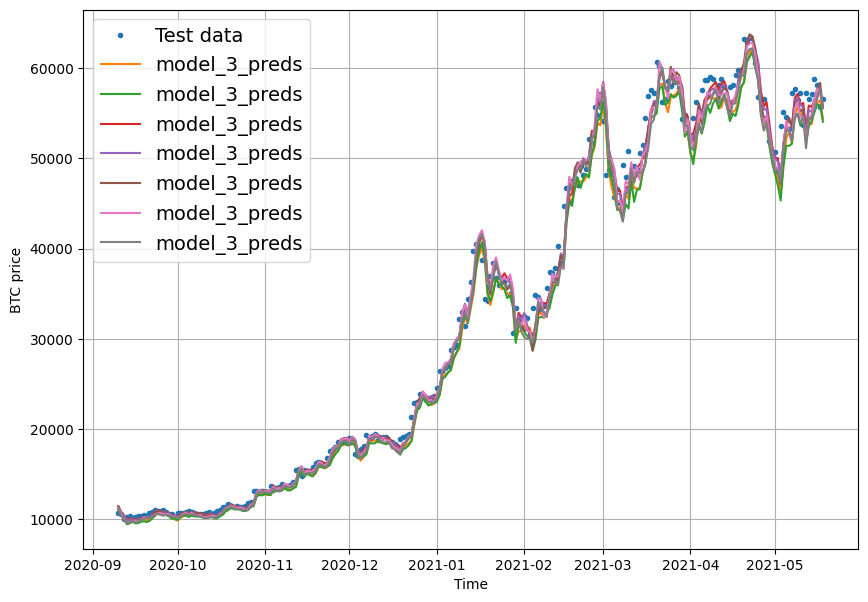

In [72]:
## Visualize the predictions
offset= 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps= X_test[-len(test_window):]
                 ,values= test_label[:,0]
                 ,start= offset
                 ,label= "Test data")
plot_time_series(timesteps= X_test[-len(test_window):]
                 ,values= model_3_preds
                 ,start= offset
                 ,label= "model_3_preds"
                 ,format= "-")

We can aggregate the model prediction

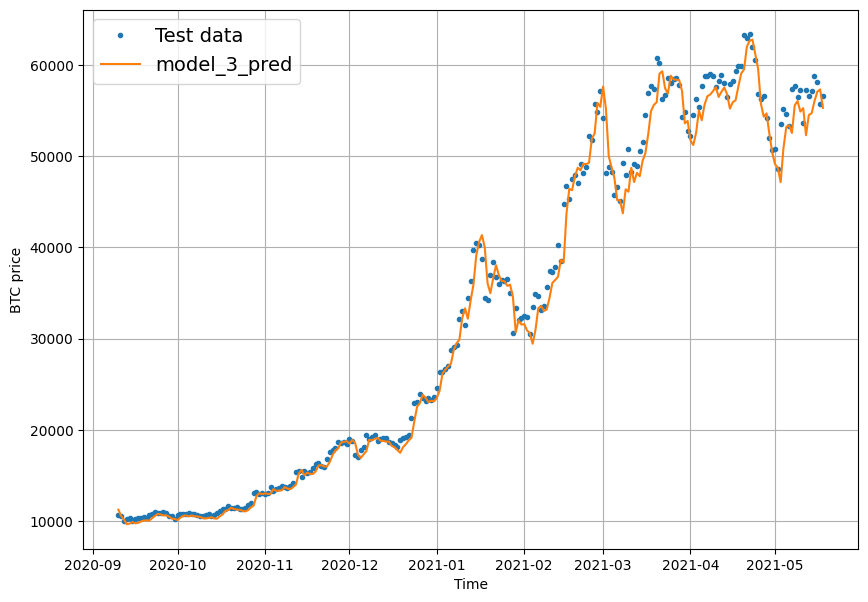

In [73]:
offset= 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_window):]
                 ,values=test_label[:,0]
                 ,start= offset
                 ,label= "Test data")
plot_time_series(timesteps=X_test[-len(test_window):]
                 ,values=tf.reduce_mean(model_3_preds,axis=1)
                 ,start= offset
                 ,label="model_3_pred"
                 ,format="-")

## Model 4: Conv1D
Our next modelling experiment.
This time we will use a Conv1D model. Conv1D can be used for a seq2seq (sequence to sequence) problems.

In our case, the input is the sequence of previous 7 days input and the output is price of bitcoin the following day. Since there are more than 1 input these kind of seq2seq problems are termed as many-to-one problem

In [74]:
HORIZON= 1
WINDOW_SIZE= 7


In [75]:
## Create windowed dataset
full_window,full_label= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_window), len(full_label)

(2780, 2780)

In [78]:
## create train test split
train_window, train_label, test_window, test_label = make_train_test_split(windows=full_window
                                                                           ,labels=full_label
                                                                           ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)

(2224, 2224, 556, 556)

The Conv1D in Tensorflow takes an input of :(`batch_size, timesteps,input_dim`)
In our case, the `batch_size` (defaults = 32) is handled for us but we need to prepare other inputs.
* `timesteps= WINDOW_SIZE` - the timeestep is also
referred to as `features`. Our `features` are the previous `WINDOW_SIZE` of bitcoin prices.
* `input_dim=HORIZON` our model views `WINDOW_SIZE` worth of data to predict `HORIZON`